# Community Solar Hardware Recommender

## Overview
Returns hardware recommendations based on various different goals

### Current Gaps
* filter hardware list, but by what? top 50%? Which is the most important characteristic?
* hardware inneficiencies
* confirm that the NREL model is based off of the weather file and that encompasses overcast chance
* change in cost of electricity from grid (and inflation) over time (see NREL levelized cost calculator
* include participation rate

### Things not included in the model
* Aggregator operational costs are not included here. The results of this study can be used for further research to attempt to design an aggregation service that can function within these parameters

## Psuedo Code

Inputs:
* Location
* Range of PV and Battery options
* Cost estimates
* Network info
* shading on an hourly basis

1) Get hourly irradiance from NREL
2) loop through every possible PV and battery combo and determine:
    * estimated hardware costs
    * estimated annual PV Wh generation (does it get curtailed if it exceeds battery capacity)?
    * maximum automated DR participation (combines battery capacity and SOA during event windows)
    * calculates ROI
3) Remove options that don't break even within 7 years from data set
4) graph all data
5) identify:
    * hardware combination with quickest ROI
    * largest PV system within 8 year ROI
    * largest Battery system within 7 year ROI
    * largest overall system within 7 year ROI
    * system with largest avoided grid consumption
    * system with largest automated DR event participation
    
## Variations to Test

* only best hardware 
    * w to wh
    * $ per wh
* only worst hardware
* afternoon call times

In [372]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import math
from scipy import stats 

In [373]:
myNetwork = 'city hall'

#Max Hardware Sizes
#500 is an estimate for the largest array someone can relatively easily install without a professional
pvMaxW = 500
#2kWh is the largest system FDNY allows without additional beurocracy 
batMaxWh = 2000

shading = .87

#totDerating = equipDerating * shading

## Commercially Available Power Station Data

Here we're interested in understanding modeling what would be representative of commercially available hardware today.

Specifically, we want to identify which characteristics best impact retail price. Because the variables in retail price are vague (i.e. sales, loss-leaders, marketing, etc.), we want to avoid over fitting, so a simple regression or median $/Wh is probably best. The regression is focused more on the relationships between data, so it might better reflect 

Similarly, max PV watts is not purely determined by battery Wh because of design and marketing choices that are not just based on maximum technical ability. (For example, a product line might use the same CC circuitry so the max PV W size is perhaps correlated to the smallest battery Wh within that group of products)

For other characteristics median is best.

In [374]:
# read in hardware data to dataframe
hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV19.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Battery Type','App Control','Bypass Mode','Min PV Voltage',
                                      'Inverter Efficiency','Inverter Watts', 'Warranty Years','Lifespan'])

print(hardware_df.shape)
hardware_df.head()

(48, 13)


,Make,Model,Battery Wh,Max PV Watt,W to Wh ratio,Max PV Voltage,Max PV Amps,Max AC Input Amps,Max AC Input Watts,Retail Price (11/12/2023),Price per Wh,Cycles,DoD
0,Jackery,Explorer 300 Plus Portable Power Station,288.00,100,0.347222,27.0,5.0,5.0,100.0,254.0,0.88,3000,80.0
1,Jackery,Explorer 700 Plus Portable Power Station,680.96,600,0.881109,60.0,11.0,15.0,1800.0,399.0,0.59,4000,70.0
2,Jackery,Explorer 1000 Plus Portable Power Station,1264.64,800,0.632591,60.0,22.0,15.0,1800.0,899.0,0.71,4000,70.0
3,Jackery,Explorer 2000 Plus Portable Power Station,2042.80,1400,0.685334,60.0,24.0,15.0,1800.0,1659.0,0.81,4000,70.0
4,Pecron,Portable Power Station,614.00,400,0.651466,18.0,7.0,NaN,NaN,299.0,0.49,3500,80.0


In [375]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(hardware_df.shape[0]))

#hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')
print('')
print('*** Wh ***')
print('Min:' + str(min(hardware_df['Battery Wh'])))
print('Max:' + str(max(hardware_df['Battery Wh'])))
print('Median:' + str(hardware_df['Battery Wh'].median()))

print('')
print('*** W ***')
print('Min:' + str(min(hardware_df['Max PV Watt'])))
print('Max:' + str(max(hardware_df['Max PV Watt'])))
print('Median:' + str(hardware_df['Max PV Watt'].median()))

print('')
print('*** W/Wh ***')
print('Min:' + str(min(hardware_df['W to Wh ratio'])))
print('Max:' + str(max(hardware_df['W to Wh ratio'])))
print('Median:' + str(hardware_df['W to Wh ratio'].median()))

print('')
print('*** Wh/$ ***')
print('Min:' + str(min(hardware_df['Price per Wh'])))
print('Max:' + str(max(hardware_df['Price per Wh'])))
print('Median:' + str(hardware_df['Price per Wh'].median()))

print('')
print('*** Cycles ***')
print('Min:' + str(min(hardware_df['Cycles'])))
print('Max:' + str(max(hardware_df['Cycles'])))
print('Median:' + str(hardware_df['Cycles'].median()))

Total Number of Companies: 16
Total Number of Products: 48

*** Wh ***
Min:99.9
Max:2232.0
Median:1088.0

*** W ***
Min:40
Max:2100
Median:400.0

*** W/Wh ***
Min:0.1015625
Max:1.025390625
Median:0.40052071300000003

*** Wh/$ ***
Min:0.44
Max:1.49
Median:0.75

*** Cycles ***
Min:2000
Max:6000
Median:3100.0


<AxesSubplot:title={'center':'Impact of Wh on Price w/ Raw Data'}, xlabel='Battery Wh', ylabel='Retail Price (11/12/2023)'>

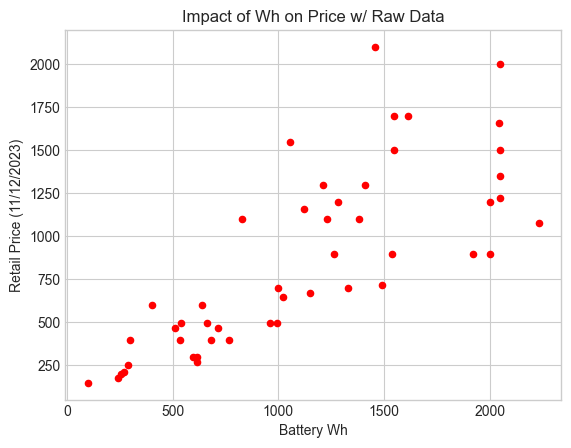

In [376]:
hardware_df.plot(kind = 'scatter', x = 'Battery Wh', y = 'Retail Price (11/12/2023)', c='red',colormap='viridis', title="Impact of Wh on Price w/ Raw Data")

In [377]:
#hardware_df.plot(kind = 'scatter', x = 'Max PV Watt', y = 'Retail Price (11/12/2023)', c='red',colormap='viridis',title="Impact of W on Price w/ Raw Data")

<AxesSubplot:title={'center':'Impact of Wh on W w/ Raw Data'}, xlabel='Battery Wh', ylabel='Max PV Watt'>

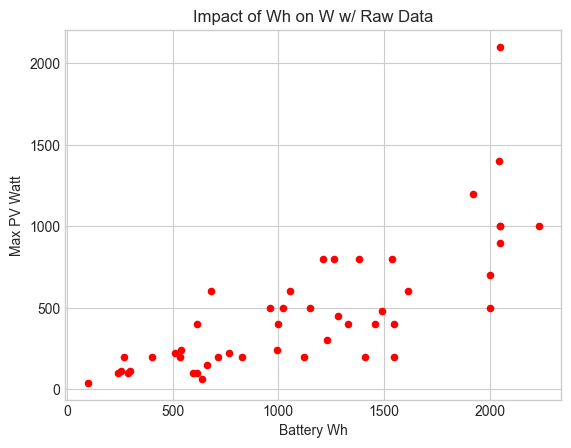

In [378]:
hardware_df.plot(kind = 'scatter', x = 'Battery Wh', y = 'Max PV Watt', c='red',colormap='viridis',title="Impact of Wh on W w/ Raw Data")

In [379]:
#Pearson Correlation Matrix

hardware_df.corr()

# Note:
# that correlations between characteristics that have the same variables or a direct relationship
# (like PV watts to W/Wh Ratio) should be ignored.


,Battery Wh,Max PV Watt,W to Wh ratio,Max PV Voltage,Max PV Amps,Max AC Input Amps,Max AC Input Watts,Retail Price (11/12/2023),Price per Wh,Cycles,DoD
Battery Wh,1.000000,0.763601,0.137238,0.487626,0.498569,0.634885,0.692476,0.779317,-0.245543,0.354455,-0.103249
Max PV Watt,0.763601,1.000000,0.678763,0.596479,0.404641,0.635489,0.842539,0.525393,-0.243645,0.290505,-0.293396
W to Wh ratio,0.137238,0.678763,1.000000,0.439092,0.156516,0.408062,0.646245,0.017546,-0.109135,0.122256,-0.425859
Max PV Voltage,0.487626,0.596479,0.439092,1.000000,0.386982,0.888635,0.903311,0.365243,-0.070264,0.108311,-0.106054
Max PV Amps,0.498569,0.404641,0.156516,0.386982,1.000000,0.709162,0.734153,0.567123,0.212628,0.552865,-0.442208
Max AC Input Amps,0.634885,0.635489,0.408062,0.888635,0.709162,1.000000,0.769122,0.503869,-0.593224,0.560112,-0.447214
Max AC Input Watts,0.692476,0.842539,0.646245,0.903311,0.734153,0.769122,1.000000,0.724922,-0.218121,0.652571,-0.717557
Retail Price (11/12/2023),0.779317,0.525393,0.017546,0.365243,0.567123,0.503869,0.724922,1.000000,0.323335,0.241509,-0.062230
Price per Wh,-0.245543,-0.243645,-0.109135,-0.070264,0.212628,-0.593224,-0.218121,0.323335,1.000000,-0.207921,0.104185
Cycles,0.354455,0.290505,0.122256,0.108311,0.552865,0.560112,0.652571,0.241509,-0.207921,1.000000,-0.308282


In [380]:
#which variables have the strongest correlation to price?

print('Notable Correlations with Raw Data:')
print("Bat Wh to Retail Price: " + str(hardware_df['Battery Wh'].corr(hardware_df['Retail Price (11/12/2023)'])))

print("Max PV Watts to Retail price: " + str(hardware_df['Max PV Watt'].corr(hardware_df['Retail Price (11/12/2023)'])))

print("Bat Wh to Max PV Watts: " + str(hardware_df['Battery Wh'].corr(hardware_df['Max PV Watt'])))


Notable Correlations with Raw Data:
Bat Wh to Retail Price: 0.7793174428755588
Max PV Watts to Retail price: 0.525392571910527
Bat Wh to Max PV Watts: 0.763601030649115


### Power Station Price

#### Open Questions

* Linear Regression vs Median - Is a linear regression over fitting?
* Is filtering for some non-correlated characteristics ok?


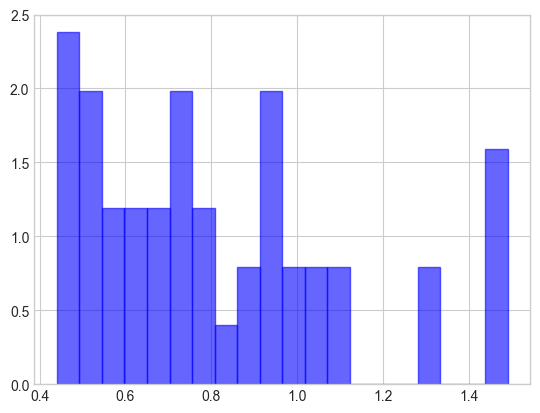

In [381]:
#price per Wh is not normally distributed
plt.hist(hardware_df['Price per Wh'], bins=20, density=True, alpha=0.6, color='b', edgecolor='b') 
  
plt.show()

0.6695366109460003
116.11163869100972
0.7793174428755589
6.812509484919555e-11
0.07937646226724207


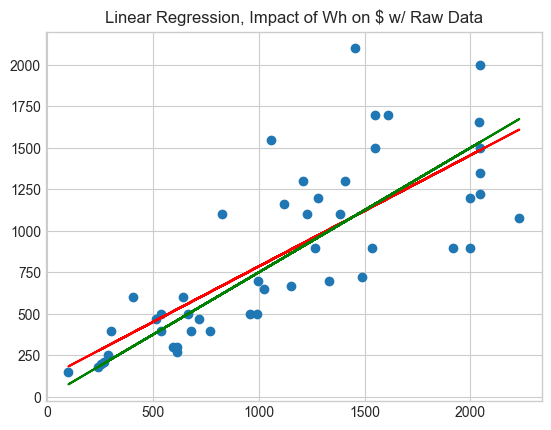

In [382]:
pSlope, pIntercept, pR, pP, pStd_err = stats.linregress(hardware_df['Battery Wh'],hardware_df['Retail Price (11/12/2023)'])
print(pSlope)
print(pIntercept)
print(pR)
print(pP)
print(pStd_err)


def powerStationPrice(x):
  return pSlope * x + pIntercept 

priceModel = list(map(powerStationPrice, hardware_df['Battery Wh']))

plt.scatter(hardware_df['Battery Wh'],hardware_df['Retail Price (11/12/2023)'])

#red is the regression line
plt.plot(hardware_df['Battery Wh'], priceModel, color='r')

#green is median price per Wh
plt.plot(hardware_df['Battery Wh'],hardware_df['Battery Wh'] * hardware_df['Price per Wh'].median(), color='g')

plt.title("Linear Regression, Impact of Wh on $ w/ Raw Data", fontdict=None, loc='center', pad=None)
plt.show()



In [383]:
print('Price Method Comparision w/ 100Wh:')
print('Regression: ' + str(powerStationPrice(100)))
print('Median: ' + str(hardware_df['Price per Wh'].median()*100))

Price Method Comparision w/ 100Wh:
Regression: 183.06529978560974
Median: 75.0


### Max PV Watts

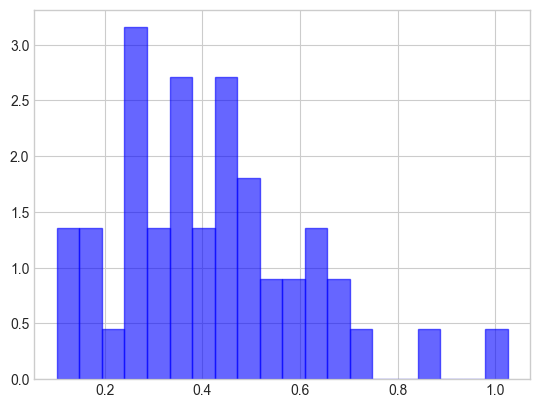

In [384]:
#W to Wh is somewhat normally distributed
plt.hist(hardware_df['W to Wh ratio'], bins=20, density=True, alpha=0.6, color='b', edgecolor='b') 
  
plt.show()

0.5141794560063055
-95.96194530116708
0.763601030649115
2.7550957790251843e-10
0.06410505248381669


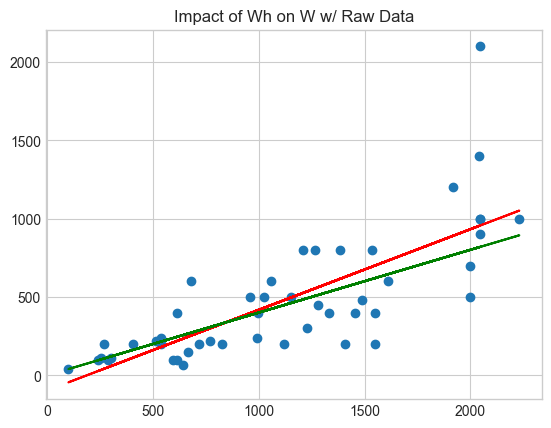

-44.543999700536524

In [385]:
wSlope, wIntercept, wR, wP, wStd_err = stats.linregress(hardware_df['Battery Wh'],hardware_df['Max PV Watt'])
print(wSlope)
print(wIntercept)
print(wR)
print(wP)
print(wStd_err)


#input battery Wh -> outputs max PV Watts
def maxPVWatts(x):
  return wSlope * x + wIntercept 

maxPVWattsModel = list(map(maxPVWatts, hardware_df['Battery Wh']))
plt.scatter(hardware_df['Battery Wh'],hardware_df['Max PV Watt'])


#red is regression slope
plt.plot(hardware_df['Battery Wh'], maxPVWattsModel,color='r')

#green is median ratio
plt.plot(hardware_df['Battery Wh'], hardware_df['Battery Wh'] * hardware_df['W to Wh ratio'].median(),color='g')

plt.title("Impact of Wh on W w/ Raw Data", fontdict=None, loc='center', pad=None)


plt.show()

maxPVWatts(100)


In [386]:
# filter hardware list to remove outliers

#remove rows with W to Wh ratios > 1
fhardware_df = hardware_df[(hardware_df['W to Wh ratio'] < 1.0)]
fhardware_df = fhardware_df[(fhardware_df['W to Wh ratio'] > .1)]

# data snapshot
print('Total Number of Companies: ' + str(fhardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(fhardware_df.shape[0]))

fhardware_df.head()

Total Number of Companies: 16
Total Number of Products: 47


,Make,Model,Battery Wh,Max PV Watt,W to Wh ratio,Max PV Voltage,Max PV Amps,Max AC Input Amps,Max AC Input Watts,Retail Price (11/12/2023),Price per Wh,Cycles,DoD
0,Jackery,Explorer 300 Plus Portable Power Station,288.00,100,0.347222,27.0,5.0,5.0,100.0,254.0,0.88,3000,80.0
1,Jackery,Explorer 700 Plus Portable Power Station,680.96,600,0.881109,60.0,11.0,15.0,1800.0,399.0,0.59,4000,70.0
2,Jackery,Explorer 1000 Plus Portable Power Station,1264.64,800,0.632591,60.0,22.0,15.0,1800.0,899.0,0.71,4000,70.0
3,Jackery,Explorer 2000 Plus Portable Power Station,2042.80,1400,0.685334,60.0,24.0,15.0,1800.0,1659.0,0.81,4000,70.0
4,Pecron,Portable Power Station,614.00,400,0.651466,18.0,7.0,NaN,NaN,299.0,0.49,3500,80.0


0.44699421845513165
-46.667437747736415
0.7998104348488629
1.5484780063398167e-11
0.050008368242415786


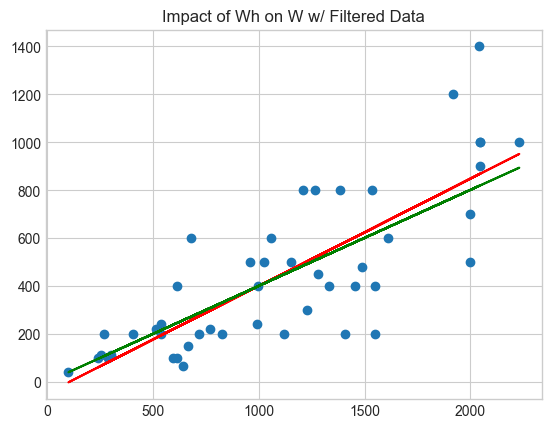

-44.543999700536524

In [387]:
wSlopeF, wInterceptF, wRF, wPF, wStd_errF = stats.linregress(fhardware_df['Battery Wh'],fhardware_df['Max PV Watt'])
print(wSlopeF)
print(wInterceptF)
print(wRF)
print(wPF)
print(wStd_errF)


#input battery Wh -> outputs max PV Watts
def maxPVWattsF(x):
  return wSlopeF * x + wInterceptF 

maxPVWattsModelF = list(map(maxPVWattsF, fhardware_df['Battery Wh']))
plt.scatter(fhardware_df['Battery Wh'],fhardware_df['Max PV Watt'])


#red is regression slope
plt.plot(fhardware_df['Battery Wh'], maxPVWattsModelF,color='r')

#green is median ratio
plt.plot(fhardware_df['Battery Wh'], fhardware_df['Battery Wh'] * fhardware_df['W to Wh ratio'].median(),color='g')

plt.title("Impact of Wh on W w/ Filtered Data", fontdict=None, loc='center', pad=None)

plt.show()

maxPVWatts(100)


In [388]:
#filter out product lines that duplicate specs
filterModels = ['EB55 Portable Power Station','EB70S Portable Power Station','AC60/P','Jump 1000','Jump 1800','P2001']

#fhardware_df = fhardware_df[~fhardware_df.Model.isin(filterModels)]
fhardware_df.shape
#hardware_productline_df.tail()

(47, 13)

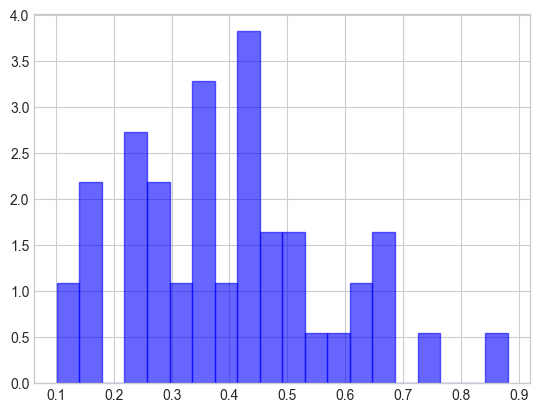

In [236]:
#W to Wh is somewhat normally distributed
plt.hist(fhardware_df['W to Wh ratio'], bins=20, density=True, alpha=0.6, color='b', edgecolor='b') 
  
plt.show()

0.44699421845513165
-46.667437747736415
0.7998104348488629
1.5484780063398167e-11
0.050008368242415786


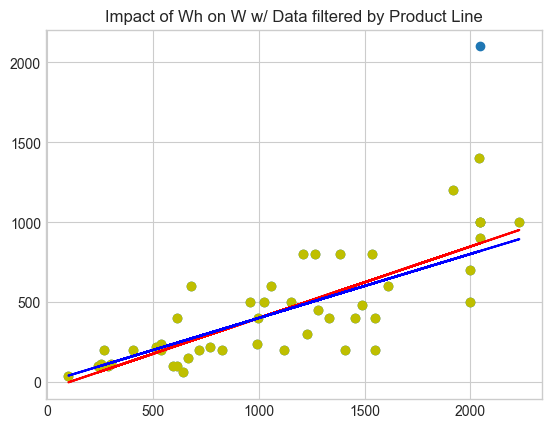

-44.543999700536524

In [237]:

wSlopeFF, wInterceptFF, wRFF, wPFF, wStd_errFF = stats.linregress(fhardware_df['Battery Wh'],fhardware_df ['Max PV Watt'])

print(wSlopeFF)
print(wInterceptFF)
print(wRFF)
print(wPFF)
print(wStd_errFF)


#input battery Wh -> outputs max PV Watts
def maxPVWattsFF(x):
  return wSlopeFF * x + wInterceptFF


maxPVWattsModelFF = list(map(maxPVWattsFF, fhardware_df['Battery Wh']))

#all products in archive
plt.scatter(hardware_df['Battery Wh'],hardware_df['Max PV Watt'])

#products filtered by product line
plt.scatter(fhardware_df['Battery Wh'],fhardware_df['Max PV Watt'], color='y')

#linear regression on products filtered by product line (this is best)
plt.plot(fhardware_df['Battery Wh'], maxPVWattsModelFF,color='r')

#linear regression w/ all data
#plt.plot(hardware_df['Battery Wh'], maxPVWattsModel,color='pink')

#median w to wh ratio
mHf = fhardware_df['W to Wh ratio'].median()
plt.plot(fhardware_df['Battery Wh'], fhardware_df['Battery Wh'] * mHf,color='b')

#yellow is median ratio for raw data
#plt.plot(hardware_df['Battery Wh'], hardware_df['Battery Wh'] * hardware_df['W to Wh ratio'].median(),color='y')


plt.title("Impact of Wh on W w/ Data filtered by Product Line", fontdict=None, loc='center', pad=None)

plt.show()

maxPVWatts(100)


### TEA Results - Representative Power Station Specs

In [391]:
#for pricing correlation coeficients and linear regression is used because it provides a clearer picture of the impact of characteristics on price (rather than simply median $ per Wh)

#median is used to characteristics that include outliers and dont have a strong correllation to other characteristics
# this includes DoD and Cycles

#80% depth of discharge for LiFePO4 batteries
LiFePOdod = fhardware_df['DoD'].median()*.01
print("Median LiFePO4 DoD: " + str(LiFePOdod))

medBatCycles = round(fhardware_df['Cycles'].median())
eol = medBatCycles / 365

print('Median battery cycles: ' + str(medBatCycles) + " (" + str(round(eol/.01)*.01) + " years)")

# check against list of hardware
# note: inv_eff' must be between 90 and 99.5 for PV Watts API
inverterEfficiency = .88

#equipment derating -> charge controller efficiency
equipDerating = .99

# check against list of hardware
# not currently used in model
#gridChargingEfficiency = .96

#battery W to Wh ratio
#should this be a regression too???
#batPVcapacity = fhardware_df['W to Wh ratio'].median()
#print('W to Wh median (filtered): ' + str(batPVcapacity))
print('Max PV Watts FF function: ' + str(wSlopeFF) + ' * Wh + ' + str(wInterceptFF))


#batteryDollarPerWh = math.floor(fhardware_df['Price per Wh'].median()*100)*.01
#print('$ per Wh median: ' + str(batteryDollarPerWh) + " dollars for 1 Wh")
print('Power Station Price function: ' + str(pSlope) + ' * Wh + ' + str(pIntercept))

# print(str(100*batteryDollarPerWh))
# powerStationPrice(100)

Median LiFePO4 DoD: 0.8
Median battery cycles: 3100 (8.49 years)
Max PV Watts FF function: 0.44699421845513165 * Wh + -46.667437747736415
Power Station Price function: 0.6695366109460003 * Wh + 116.11163869100972


## Con Ed Network Data

In [239]:
# read in hardware data to dataframe

networks_df = pd.read_csv('data/conEdNetworks2023-cleaned.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,14:00,18:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,1
4,bronx,southeast bronx,16:00,20:00,2


In [240]:
#retrieve network info

networkInfo = networks_df.loc[networks_df['network']== myNetwork]

print(networkInfo)

tier = networkInfo['tier'].iloc[0]
borough = networkInfo['borough'].iloc[0]

startTime =int(networkInfo['start time'].iloc[0].split(":")[0])

      borough    network start time end time  tier
23  manhattan  city hall      11:00    15:00     1


In [241]:
#DR variables


#tier 2 networks pay at a higher rate
if tier == 1:
    DLRPratePerkW = 18
else:
    DLRPratePerkW = 25

print("DLRP rate: " + str(DLRPratePerkW))

#westchester and staten island pay at a lower rate
if borough not in ['westchester','staten island']:
    CSRPratePerkW = 18
else:
    CSRPratePerkW = 6

print("CSRP rate: " + str(CSRPratePerkW))

#performance rates aren't currently used in this model
CSRPperfRatePerkW = 1
DLRPperfRatePerkW = 1

#this is the monthly reservation payment
totDRratePerkW = CSRPratePerkW + DLRPratePerkW

DLRP rate: 18
CSRP rate: 18


## Solar Access

To do:
* Shading
* capacity factor? 14% NOT NECESSARILY BECAUSE THE NREL DATA IS ALREADY BASED ON WEATHER!

In [242]:
#PV Installation Details
lat = 40.7128
long = 74.0060

#seasonal tilt options: summer, winter, average
season = 'summer'

azimuth = 170

In [396]:
 #api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#response-fields
    
def pvWattsRequest(lat, season):
        
    if season == 'summer':
        s = -15
    elif season == 'winter':
        s = 15
    else:
        s = 0
        
    #shading = 0
        
    # api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#request-url
    nAzimuth = str(azimuth) #cardinal direction
    nCapkW = str(.05) #nameplate capacity minimum 0.05*
    nLat = str(lat) #latitude
    nTilt = str(lat + s)
    nLosses = str(shading * equipDerating) #derating*
    nInvEff = str(max(90,inverterEfficiency * 100)) #inverter efficiency - cannot be under 90% for API*
    nBorough = borough
    nTimeframe = 'hourly'
    nrelKey = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'
    getURL = 'https://developer.nrel.gov/api/pvwatts/v8.json?api_key=' + nrelKey + '&azimuth=' + nAzimuth+'&system_capacity=' + nCapkW +'&losses=' + nLosses +'&array_type=1&module_type=0&inv_eff=' + nInvEff + '&tilt=' +  nTilt +'&address=' + nBorough +',ny&timeframe=' + nTimeframe

    #print(getURL)
    return getURL

#we care about hourly plane of array irradiance (POA)
# we can also get hourly DC output, but we'll quickly exceed the 1000 calls an hour max...
# *doesn't impact POA

nrelData = requests.get(pvWattsRequest(lat, season)).json()['outputs']
print(nrelData)

{'ac_monthly': [4.592319721045637, 5.158067502473336, 6.113334154000804, 6.768028355373083, 7.271783713734, 7.327661524165989, 7.550572709158877, 6.984106194448626, 6.367169061436878, 5.242806991425379, 4.028851006247755, 3.697799296488634], 'poa_monthly': [98.61403650172664, 112.9607077624791, 139.6171340868954, 156.8364403526696, 174.2376350850779, 179.4767476622332, 187.7095021228868, 174.0208174800289, 154.0629227619962, 120.6265612681154, 89.59338237140902, 79.74561766761994], 'solrad_monthly': [3.181097951668602, 4.03431099151711, 4.503778518932108, 5.227881345088987, 5.620568873712189, 5.982558255407772, 6.055145229770541, 5.613574757420287, 5.135430758733207, 3.891179395745657, 2.986446079046968, 2.572439279600643], 'dc_monthly': [5.121369601671145, 5.777605149379519, 6.915245113661059, 7.57607285627481, 8.127436913570563, 8.16733305148611, 8.415625413225465, 7.786863408881463, 7.095856964792077, 5.848774910660612, 4.495496473432879, 4.127328849158078], 'ac_annual': 71.10250022

In [397]:
#Annual PV Production w/ 50W module

print((sum(nrelData['poa_monthly'])/12) *.05 * 365 * .99 * .9)

print(sum(nrelData['dc_monthly'])* .99 * .9)

print(sum(nrelData['ac_monthly']))
print(nrelData['ac_annual'])

print(nrelData['solrad_annual']*365*.05 * .99 * .9)

print(sum(nrelData['poa'])*.001 * 0.05 * .9 * .99)

print('')
print('Estimated annual AC production with 50W module (they are all different):')

#multiply this by PV module size
# DC output = annual daily sun hour average * 365 days * cc efficiency * shade losses * module W
# AC output = DC output * inverter efficiency
print('ac_annual kW NREL: ' + str(nrelData['ac_annual']))

dailyAvgRad = nrelData['solrad_annual']

#this is what we use when we calculate all our options...
dcOutputFactors = dailyAvgRad * 365 * equipDerating * shading

#convert to kW
print('ac annual kW calculated from annual average radiation: ' + str(dcOutputFactors * 50 * .001 * inverterEfficiency))

#yet another way to calculate annaul AC output (USE THIS)
print('ac annual kW calculated from predicted monthly DC output:' + str(sum(nrelData['dc_monthly'])*inverterEfficiency))

hourlyPOA = nrelData['poa']
hourlyDC = nrelData['dc']

#print(hourlyPOA)

2259.5687582859223
70.79441275721867
71.102500229999
71.10250022999911
74.26340277236751
74.2871924041498

Estimated annual AC production with 50W module (they are all different):
ac_annual kW NREL: 71.10250022999911
ac annual kW calculated from annual average radiation: 63.17340129169396
ac annual kW calculated from predicted monthly DC output:69.92040766145053


## Grid Electricity Costs

Needed:
how to factor in annual increases?

In [245]:
# GRID ELECTRICITY COSTS
def avoidedUtilityCosts(generatedkWAC):
    supplyChargeDollarsPerkWh = .09453
    deliveryChargeDollarsPerkWh = .15653
    systemBenefitChargeDollarsPerkWh = .00520
    salesTax = .045
    gridDollarPerkW = (supplyChargeDollarsPerkWh + deliveryChargeDollarsPerkWh + systemBenefitChargeDollarsPerkWh) * (1 + salesTax)
    #print("Con Ed $ per kWh = " + str(gridDollarPerkW))

    annualAvoidedCosts = generatedkWAC * gridDollarPerkW
    
    return annualAvoidedCosts

## Hardware Costs

In [246]:
# HARDWARE COSTS

'''
I'm looking levelized cost - see NREL's report
'''
#variable costs
pvDollarPerW = 1.0 
mountDollarPerW = .4

#fixed costs
bosCost = 10 #bos includes cables, insulation when bringing cables in probably via window
smartController = 100
operatingCosts = 0 #DR aggregation operator costs are not considered here. 
fixedHardwareCosts = bosCost + smartController + operatingCosts

def hardwareCosts(pvW, batWh):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    # average cost of PV modules per kW
    
    variableCosts = powerStationPrice(batWh) + (pvW * (pvDollarPerW + mountDollarPerW))

    #fixed costs
    bosCost = 10 #bos includes cables, insulation when bringing cables in probably via window
    smartController = 100
    operatingCosts = 0 #DR aggregation operator costs are not considered here. 
    fixedHardwareCosts = bosCost + smartController + operatingCosts

    c = fixedHardwareCosts + variableCosts
    return c

print(hardwareCosts(100, 500))

#this is for testing existing battery systems with this model
def hardwareCostsFixedBattery(pvW):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    # average cost of PV modules per kW

    variableCosts = (pvW * (pvDollarPerW + mountDollarPerW))


    c = fixedHardwareCosts + variableCosts
    return c

print(hardwareCostsFixedBattery(100))


700.8799441640099
250.0


In [247]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts
def maxDRParticipation(batWh, pvW):
    batteryACOutput = batWh * LiFePOdod * inverterEfficiency * .25
    
    runningTot = 0

    #days in the months May - September
    #daysInMonth = [31,30,31,31,30]
    
    #returns average PV generated for all window hours
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    for d in range(121, 274):
        drEventWindowPOA = 0
        drEventDCWh = 0
        for e in range(startTime,startTime + 4):
            #POA for 1 hour during the event window
            drHour = ((d-1)*24)+e
            #drEventWindowPOA = drEventWindowPOA + hourlyPOA[drHour]
            #this gets scaled because its based on a 50W module
            drEventDCWh = drEventDCWh + (hourlyDC[drHour] * (pvW/50))
        
        #this is average to an hourly basis NOT the total production during the event
        runningTot = runningTot + (drEventDCWh/4)
        
        '''
        print((drEventWindowPOA/1000)*pvW * totDerating)
        print(drEventDCWh)
        print('')
        '''
    
    numDays = 274-121
    avgEventPVWhAC = (runningTot/numDays) * inverterEfficiency
    #print(avgEventPVWhAC)
    return avgEventPVWhAC + batteryACOutput

maxDRParticipation(1000, 500) * .001 * 36 * 5

79.74308647058822

In [248]:
'''
maximum amount of DR participation based on sum of:
battery capacity (assumes battery is full at start of DR event)
PV generation during event
'''
'''
maxAutoParticipation= (batterykWh * .25) + (pvWatts * eventSunHours * derating)
maxAutoDRGross = maxAutoParticipation * (CSRPratePerkW + DLRPratePerkW)

maxAvoidedEnergyConsumption = annualPVWatts

'''

data = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[]
}


#battery watt hour loop 50 - 2000 incrementing by 50
for b in range(1,int(batMaxWh / 50)+1):
    bWh = b * 50
    
    maxPV = min(bWh * batPVcapacity, pvMaxW)
    #pv watts loop 50-500 incrementing by 10
    for p in range(1,int(maxPV / 10)+1):
        
        pW = p * 10
        #print(p * 10)
        
        #PV Watts
        data['pvW'].append(pW)
        #Battert Watt Hours
        data['batWh'].append(bWh)
        #Hardware Costs in Dollars
        hC = hardwareCosts(pW,bWh)
        data['hardwareDollars'].append(hC)
        #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
        pvDCkWh = dcOutputFactors * .001 * pW
        data['annualPVkWh'].append(pvDCkWh)
        #Annual PV generation converted to AC
        pvACkWh = pvDCkWh * inverterEfficiency
        data['annualPVkWhAC'].append(pvACkWh)
        #total annual avoided grid consumption i.e. AC solar generation
        avoidedCosts = avoidedUtilityCosts(pvACkWh)
        data['avoidedGridCosts'].append(avoidedCosts)
        # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  
        maxParW = maxDRParticipation(bWh,pW)
        data['maxAutoParticipation'].append(maxParW)
        # minimum participants in aggregation if using homogenous systems
        data['minParticipants'].append(math.ceil(50000 / maxParW))
        #monthly income from DR participation
        drInc = (maxParW* 0.001 * totDRratePerkW)
        data['drInc'].append(drInc)
        #annual income from DR participation
        data['drIncAnn'].append(drInc * 5)
        #annual income
        inc = avoidedCosts + (drInc * 5)
        data['annualIncome'].append(inc)
        data['roi'].append(hC/inc)

#load data into a DataFrame object:
df = pd.DataFrame(data)

print(str(df.shape[0])+ ' total hardware combinations generated')

print(df.head())
print('--------------------------------------------------------')
print(df.tail())

1400 total hardware combinations generated
   pvW  batWh  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   10     50       273.588469    14.357591      12.921832   
1   20     50       287.588469    28.715182      25.843664   
2   10    100       307.065300    14.357591      12.921832   
3   20    100       321.065300    28.715182      25.843664   
4   30    100       335.065300    43.072774      38.765496   

   maxAutoParticipation  minParticipants  annualIncome        roi  \
0             14.260343             3507      6.027221  45.392141   
1             19.520686             2562     10.434442  27.561461   
2             23.260343             2150      7.647221  40.153841   
3             28.520686             1754     12.054442  26.634604   
4             33.781029             1481     16.461663  20.354280   

   avoidedGridCosts     drInc  drIncAnn  
0          3.460359  0.513372  2.566862  
1          6.920719  0.702745  3.513723  
2          3.460359  0.837372  4.186862  
3

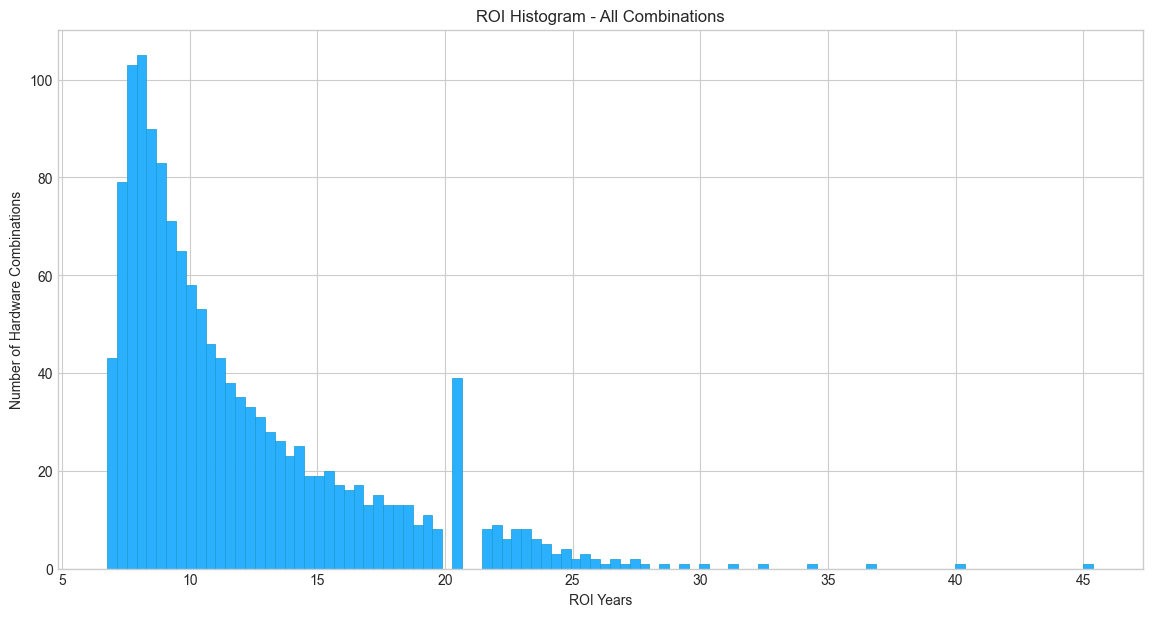

In [249]:
#ROI histogram

#n, bins, patches = plt.hist(df['roi'], 100, density=False, facecolor='g', alpha=0.75)

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df['roi'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('ROI Histogram - All Combinations') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

#style source: https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca

375 hardware combinations with favorable ROI


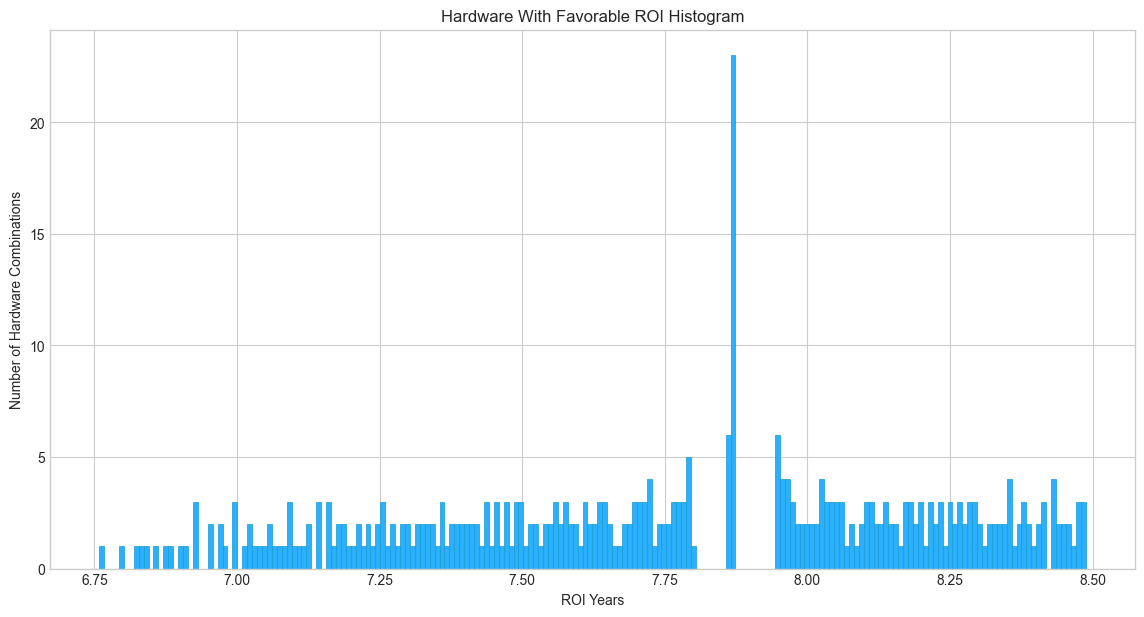

In [250]:
favROI_df = df[df['roi'] <= eol] 

print(str(favROI_df.shape[0])+ ' hardware combinations with favorable ROI')

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

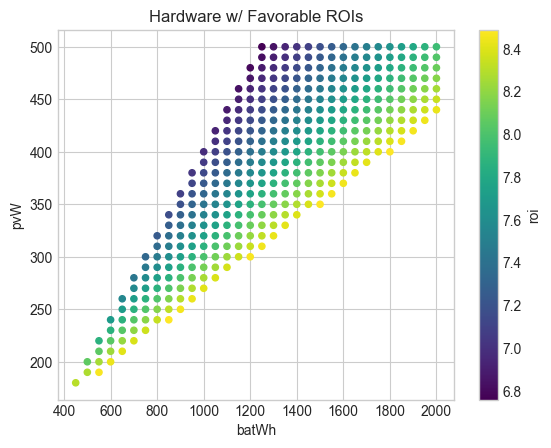

In [251]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis', title='Hardware w/ Favorable ROIs')

#df.show()

# df.savefig('foo.png')

# Results

### Most Favorable ROI

In [252]:
#most favorable ROI
favROI_df[favROI_df['roi'] == min(favROI_df['roi'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
649,500,1250,1763.032402,717.87956,646.091604,488.017147,103,260.861055,6.758511,173.017969,17.568617,87.843086


### PV System Range

In [253]:
#smallest PV system
favROI_df[favROI_df['pvW'] == min(favROI_df['pvW'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
89,180,450,779.403114,258.436642,232.592977,175.686173,285,93.90998,8.299471,62.286469,6.324702,31.623511


In [254]:
#largest PV systems
largePV = favROI_df[favROI_df['pvW'] == max(favROI_df['pvW'])] 
largePV

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
649,500,1250,1763.032402,717.87956,646.091604,488.017147,103,260.861055,6.758511,173.017969,17.568617,87.843086
699,500,1300,1796.509233,717.87956,646.091604,497.017147,101,262.481055,6.844339,173.017969,17.892617,89.463086
749,500,1350,1829.986063,717.87956,646.091604,506.017147,99,264.101055,6.929113,173.017969,18.216617,91.083086
799,500,1400,1863.462894,717.87956,646.091604,515.017147,98,265.721055,7.012854,173.017969,18.540617,92.703086
849,500,1450,1896.939725,717.87956,646.091604,524.017147,96,267.341055,7.095580,173.017969,18.864617,94.323086
899,500,1500,1930.416555,717.87956,646.091604,533.017147,94,268.961055,7.177309,173.017969,19.188617,95.943086
949,500,1550,1963.893386,717.87956,646.091604,542.017147,93,270.581055,7.258059,173.017969,19.512617,97.563086
999,500,1600,1997.370216,717.87956,646.091604,551.017147,91,272.201055,7.337849,173.017969,19.836617,99.183086
1049,500,1650,2030.847047,717.87956,646.091604,560.017147,90,273.821055,7.416694,173.017969,20.160617,100.803086
1099,500,1700,2064.323877,717.87956,646.091604,569.017147,88,275.441055,7.494612,173.017969,20.484617,102.423086


###  Battery System Range

In [255]:
#smallest Bat system
favROI_df[favROI_df['batWh'] == min(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
89,180,450,779.403114,258.436642,232.592977,175.686173,285,93.90998,8.299471,62.286469,6.324702,31.623511


In [256]:
#larget bat systems
favROI_df[favROI_df['batWh'] == max(favROI_df['batWh'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1393,440,2000,2181.184861,631.734013,568.560612,591.455089,85,258.717729,8.430751,152.255813,21.292383,106.461916
1394,450,2000,2195.184861,646.091604,581.482444,596.715432,84,263.124950,8.342747,155.716172,21.481756,107.408778
1395,460,2000,2209.184861,660.449195,594.404276,601.975775,84,267.532171,8.257642,159.176532,21.671128,108.355640
1396,470,2000,2223.184861,674.806787,607.326108,607.236118,83,271.939392,8.175295,162.636891,21.860500,109.302501
1397,480,2000,2237.184861,689.164378,620.247940,612.496461,82,276.346613,8.095575,166.097250,22.049873,110.249363
1398,490,2000,2251.184861,703.521969,633.169772,617.756804,81,280.753834,8.018358,169.557610,22.239245,111.196225
1399,500,2000,2265.184861,717.879560,646.091604,623.017147,81,285.161055,7.943528,173.017969,22.428617,112.143086


### Largest System

In [257]:
#largest overall system
largestSystem = largePV[largePV['batWh'] == max(largePV['batWh'])] 
largestSystem

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1399,500,2000,2265.184861,717.87956,646.091604,623.017147,81,285.161055,7.943528,173.017969,22.428617,112.143086


### Upfront Costs

In [258]:
#cheapest upfront cost
favROI_df[favROI_df['hardwareDollars'] == min(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
89,180,450,779.403114,258.436642,232.592977,175.686173,285,93.90998,8.299471,62.286469,6.324702,31.623511


In [259]:
#most expensive upfront cost
favROI_df[favROI_df['hardwareDollars'] == max(favROI_df['hardwareDollars'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1399,500,2000,2265.184861,717.87956,646.091604,623.017147,81,285.161055,7.943528,173.017969,22.428617,112.143086


### DR Impact

In [260]:
#best automated DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == max(favROI_df['maxAutoParticipation'])] 

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
1399,500,2000,2265.184861,717.87956,646.091604,623.017147,81,285.161055,7.943528,173.017969,22.428617,112.143086


In [261]:
#worst DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 


,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn
89,180,450,779.403114,258.436642,232.592977,175.686173,285,93.90998,8.299471,62.286469,6.324702,31.623511


In [262]:
#ratio of DR income to avoided electricity costs
incRatio = favROI_df['drIncAnn']/ favROI_df['avoidedGridCosts']

print('Ratio of financial benefit sources (DR income / avoided grid costs )')
print('The higher the number, the greater the share DR income played in reaching the ROI. This is important for aligning personal incentives with grid needs')
print('Min: ' + str(min(incRatio)))
print('Max: ' + str(max(incRatio)))

      #how many DR participants are required to meet the minimum requirements?

Ratio of financial benefit sources (DR income / avoided grid costs )
The higher the number, the greater the share DR income played in reaching the ROI. This is important for aligning personal incentives with grid needs
Min: 0.5077107711220129
Max: 0.6992305527001635


### Greatest Income after ROI is reached up to EOL

In [263]:
# income from ROI to EOL 
# iar = income after return

       
print("Avg Cycles in Years: " + str(eol))
print('')

favROI_df['iar'] = (eol - favROI_df['roi']) * favROI_df['annualIncome']

print(max(favROI_df['iar']))

favROI_df[favROI_df['iar'] == max(favROI_df['iar'])] 


minIar = round(min(favROI_df['iar'])*100)*.01
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(favROI_df['iar'])*100)*.01
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")


Avg Cycles in Years: 8.493150684931507

452.4998497630839
Minimum IAR: $1.03 ($0.10300000000000001/yr for 10 years)
Maximum IAR: $452.5 ($45.25/yr for 10 years)


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Applying Existing Hardware to Model

In [264]:
# Get ROI for all hardware listed

#loop through all products

#get upfront costs w/ modules

rData = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[],
    'Cycles':[]
}
    
#loop through all batteries in database
for b in range(hardware_df.shape[0]):
    
    d = hardware_df.iloc[b]
    
    #pv watts loop 50-500 incrementing by 10
    for pW in range(50,min(500,math.floor(d['Max PV Watt']))+10,10):
        
        bWh = d['Battery Wh']
        
        #PV Watts
        rData['pvW'].append(pW)
        #Battery Watt Hours
        rData['batWh'].append(bWh)
        #Hardware Costs in Dollars
        hC = hardwareCostsFixedBattery(pW) + d['Retail Price (11/12/2023)']
        rData['hardwareDollars'].append(hC)
        #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
        pvDCkWh = dcOutputFactors * .001 * pW
        rData['annualPVkWh'].append(pvDCkWh)
        #Annual PV generation converted to AC
        pvACkWh = pvDCkWh * inverterEfficiency
        rData['annualPVkWhAC'].append(pvACkWh)
        #total annual avoided grid consumption i.e. AC solar generation
        avoidedCosts = avoidedUtilityCosts(pvACkWh)
        rData['avoidedGridCosts'].append(avoidedCosts)
        # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  
        maxParW = maxDRParticipation(bWh,pW)
        rData['maxAutoParticipation'].append(maxParW)
        # minimum participants in aggregation if using homogenous systems
        rData['minParticipants'].append(math.ceil(50000 / maxParW))
        #monthly income from DR participation
        drInc = (maxParW* 0.001 * totDRratePerkW)
        rData['drInc'].append(drInc)
        #annual income from DR participation
        rData['drIncAnn'].append(drInc * 5)
        #annual income
        inc = avoidedCosts + (drInc * 5)
        rData['annualIncome'].append(inc)
        rData['roi'].append(hC/inc)
        rData['Cycles'].append(d['Cycles'])

#load data into a DataFrame object:
productTest_df = pd.DataFrame(rData)

print(str(productTest_df.shape[0])+ ' total hardware combinations generated')

print(productTest_df.head())

1421 total hardware combinations generated
   pvW  batWh  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   50  288.0            434.0    71.787956      64.609160   
1   60  288.0            448.0    86.145547      77.530992   
2   70  288.0            462.0   100.503138      90.452825   
3   80  288.0            476.0   114.860730     103.374657   
4   90  288.0            490.0   129.218321     116.296489   

   maxAutoParticipation  minParticipants  annualIncome        roi  \
0             78.141715              640     31.367306  13.836062   
1             83.402058              600     35.774527  12.522877   
2             88.662401              564     40.181748  11.497758   
3             93.922744              533     44.588969  10.675286   
4             99.183086              505     48.996190  10.000778   

   avoidedGridCosts     drInc   drIncAnn  Cycles  
0         17.301797  2.813102  14.065509    3000  
1         20.762156  3.002474  15.012370    3000  
2         24.222

In [279]:
usable_products_df = favROI_products_df[favROI_products_df['batWh'] <= 2000] 


productTest_df['Cycles']

0       3000
1       3000
2       3000
3       3000
4       3000
        ... 
1416    3500
1417    3500
1418    3500
1419    3500
1420    3500
Name: Cycles, Length: 1421, dtype: int64

In [356]:
# I think adding in cycles broke it...I think its because of the 1 system with 6000cycles...

favROI_products_df = usable_products_df[usable_products_df['roi'] <= (usable_products_df['Cycles']/365)] 
favROI_products_df = usable_products_df[usable_products_df['roi'] <= 10] 

favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 

favROI_products_df

,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn,Cycles,iar
11,100,680.96,649.0,143.575912,129.218321,175.176229,286,66.135315,9.813214,34.603594,6.306344,31.531721,4000,75.770576
12,110,680.96,663.0,157.933503,142.140153,180.436572,278,70.542536,9.398585,38.063953,6.495717,32.478583,4000,110.068890
13,120,680.96,677.0,172.291094,155.061985,185.696915,270,74.949757,9.032718,41.524313,6.685089,33.425445,4000,144.367203
14,130,680.96,691.0,186.648686,167.983817,190.957258,262,79.356978,8.707489,44.984672,6.874461,34.372306,4000,178.665517
15,140,680.96,705.0,201.006277,180.905649,196.217601,255,83.764200,8.416483,48.445031,7.063834,35.319168,4000,212.963831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,460,2000.00,1653.0,660.449195,594.404276,601.975775,84,267.532171,6.178696,159.176532,21.671128,108.355640,3500,912.376983
1417,470,2000.00,1667.0,674.806787,607.326108,607.236118,83,271.939392,6.130042,162.636891,21.860500,109.302501,3500,940.638007
1418,480,2000.00,1681.0,689.164378,620.247940,612.496461,82,276.346613,6.082940,166.097250,22.049873,110.249363,3500,968.899031
1419,490,2000.00,1695.0,703.521969,633.169772,617.756804,81,280.753834,6.037317,169.557610,22.239245,111.196225,3500,997.160056


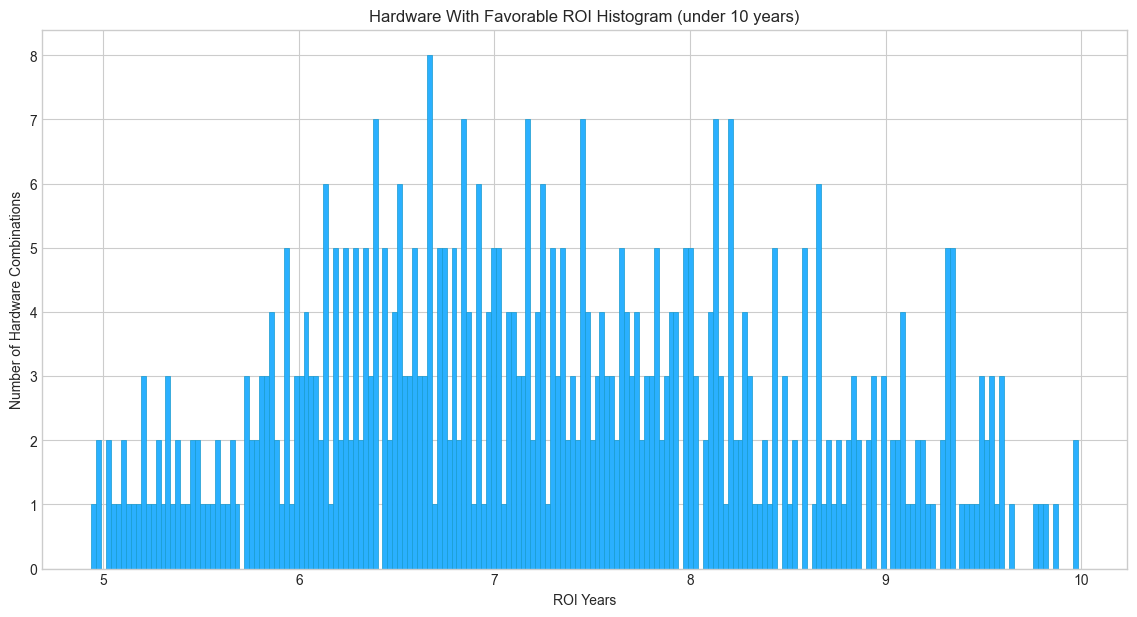

In [358]:

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_products_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram (under 10 years)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

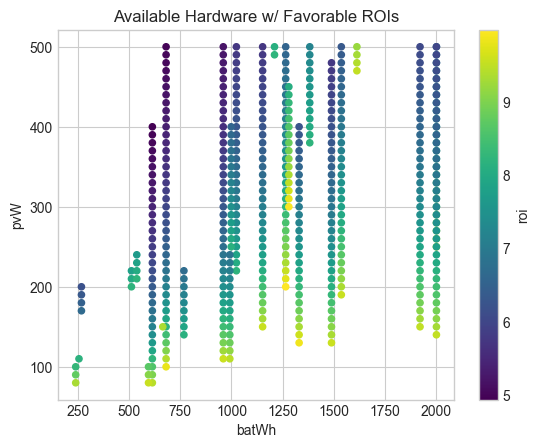

In [359]:
#filter out products over 2kWh
usable_products_df = favROI_products_df[favROI_products_df['batWh'] <= 2000] 


usable_products_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


In [275]:
# income from ROI to EOL 
# iar = income after return
#print(favROI_products_df['Cycles']/365)

usable_products_df['iar'] = ((usable_products_df['Cycles']/365) - usable_products_df['roi']) * usable_products_df['annualIncome']

print(max(usable_products_df['iar']))

usable_products_df[usable_products_df['iar'] == max(usable_products_df['iar'])] 


minIar = round(min(usable_products_df['iar'])*100)*.01
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(usable_products_df['iar'])*100)*.01
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")

2001.8676703148267
Minimum IAR: $0.13 ($0.013000000000000001/yr for 10 years)
Maximum IAR: $2001.8700000000001 ($200.187/yr for 10 years)


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Discussion

Operational costs may be able to be met from the DR income after ROI has been reached

* What is the income from the point of ROI to end of life?

In [269]:
# Notes

looks at micro adjustments - exactly because of small amounts of energy

software diagram!

battery stuff for Koushick

value of resiliency? 

SyntaxError: invalid syntax (539148002.py, line 3)